In [1]:
import sys
sys.path.append("../core")
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_probability as tfp
from tensorflow.keras import layers
from skimage.transform import resize
import time

tfd = tfp.distributions
tfb = tfp.bijectors

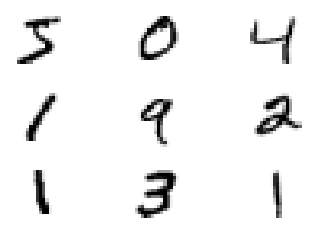

In [2]:
# loading MNIST data
mnist = tf.keras.datasets.mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0
N = x_train.shape[0]
h,w = 20,20
x_train_ds = np.zeros((N,h,w))
for i in range(N):
    x_train_ds[i,...] = resize(x_train[i,...], (h, w))
    
fig, axes = plt.subplots(3,3)
[axi.set_axis_off() for axi in axes.ravel()]
n = 0
for i in range(3):
    for j in range(3):
        axes[i,j].imshow(x_train_ds[n,...], cmap = matplotlib.cm.binary, interpolation="nearest")
        n += 1
x_train_ds = tf.cast(tf.reshape(x_train_ds,[-1,h,w,1]),dtype=tf.float32)

In [3]:
def make_gen(latent_map_dim):
    model = tf.keras.Sequential()
    model.add(layers.Dense(4*4*500, use_bias=False, input_shape=(latent_map_dim,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((4, 4, 500)))
    assert model.output_shape == (None, 4, 4, 500) # Note: None is the batch size

    model.add(layers.Conv2DTranspose(200, (4, 4), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 8, 8, 200)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(100, (4, 4), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, 8, 8, 100)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    
    model.add(layers.Conv2DTranspose(100, (4, 4), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 16, 16, 100)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    
    model.add(layers.Reshape((10, 20, 128)))
    assert model.output_shape == (None, 10, 20, 128)

    model.add(layers.Conv2DTranspose(1, (4, 4), strides=(1, 1), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 10 ,20, 1)

    return model


def make_disc_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(100, (4, 4), strides=(2, 2), padding='same',
                                     input_shape=[20, 20, 1]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(50, (4, 4), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))
    
    model.add(layers.Conv2D(20, (4, 4), strides=(1, 1), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1,activation='sigmoid'))

    return model

class T_gen(tf.keras.Model):
    
    def __init__(self):
        super(T_gen,self).__init__(name='T')
        self.K = make_gen(10*20)
        self.F = make_gen(20*20)
        
    def call(self, inputs,training=True):
        x = inputs[...,:10*20]
        y = inputs[...,10*20:]
        T1 = self.K(x,training)
        T1_flattened = tf.reshape(T1,[-1,10*20])
        T2 = self.F(tf.concat([T1_flattened,y],axis=-1),training)
        
        return tf.concat([T1,T2],axis = 1)

In [8]:
# Using Adam Optimizer for minimizing the Generator and Discriminator loss
BATCH_SIZE = 128
BUFFER_SIZE = N
latent_dim = 20*20
lamda = 0.01 # monoticity lagrange multiplier 
N_epochs = 100

train_dataset = tf.data.Dataset.from_tensor_slices(x_train_ds).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

f = make_disc_model()
T = T_gen()

def gen_loss():
    z1 = tf.random.normal([BATCH_SIZE,latent_dim])
    z2 = tf.random.normal([BATCH_SIZE,latent_dim])
    T1 = T(z1)
    T2 = T(z2)
    g_loss_fake = tf.reduce_mean(tf.math.log(f(T1)),axis=0)
    m_loss = lamda*tf.reduce_mean(tf.reduce_sum(tf.reshape(T1-T2,[-1,20*20])*(z1-z2),axis=1))
    g_loss = g_loss_fake + m_loss
    return -g_loss

def disc_loss(x):
    z = tf.random.normal([BATCH_SIZE,latent_dim])
    d_loss_real = tf.reduce_mean(tf.math.log(f(x)),axis=0)
    d_loss_fake = tf.reduce_mean(tf.math.log(1.0-f(T(z))),axis=0)
    d_loss = d_loss_real+d_loss_fake
    return -d_loss

def grid_plot():
    N_samples= 4
    b = tf.constant([N_samples,1,1], tf.int32)
    zero_array = tf.zeros([10,20])
    fig, ax = plt.subplots(10,N_samples+2,figsize=(10,10))
    [axi.set_axis_off() for axi in ax.ravel()]

    y_label = 0
    for i in range(10):
        x_digit = x_train_ds[y_train == y_label][0,...,0]
        x_obs = x_digit[:10]
        x_obs_im = tf.concat([x_obs,zero_array],axis=0)
        ax[i,0].imshow(x_digit,cmap = matplotlib.cm.binary, interpolation="nearest")
        ax[i,1].imshow(x_obs_im,cmap = matplotlib.cm.binary, interpolation="nearest")
        x_obs_tiled = tf.tile(tf.reshape(x_obs,[1,10,20]), b)
        x_obs_flattened = tf.reshape(x_obs_tiled,[-1,10*20])
        u = tf.random.normal([N_samples,10*20])
        y_samples = T.F(tf.concat([x_obs_flattened,u],axis=-1),training=False)[...,0]
        for j in range(N_samples):
            image_inpaint = tf.concat([x_obs,y_samples[j]],axis=0)
            ax[i,j+2].imshow(image_inpaint,cmap = matplotlib.cm.binary, interpolation="nearest")
        y_label += 1

    fig.text(0.165,0.1,'truth')
    fig.text(0.305,0.1,'$x^*$')
    fig.text(0.6,0.1,'$y|x^*$ samples')
    plt.pause(0.5)
    #plt.savefig('MNIST_inpainting_200_epochs.png')

it: 0 time: 59.19046902656555 D loss: [1.3010166] G loss: [-1.253412]


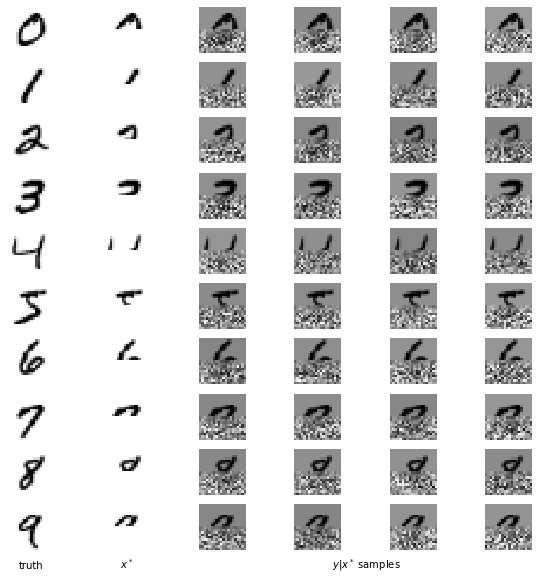

it: 5 time: 340.89946699142456 D loss: [1.1061456] G loss: [0.5171791]


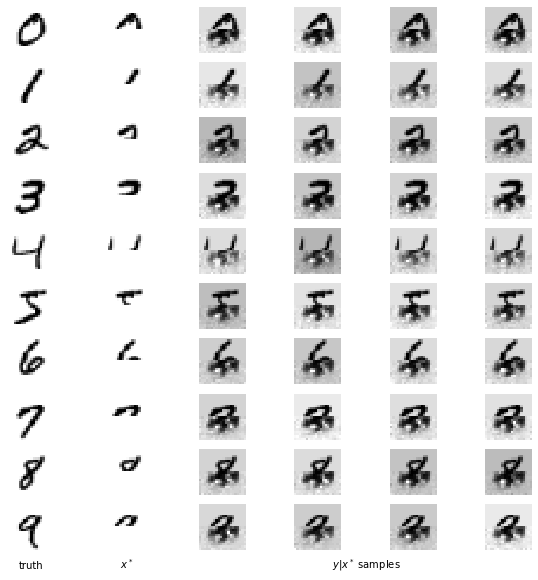

it: 10 time: 625.910920381546 D loss: [0.7773609] G loss: [0.92438906]


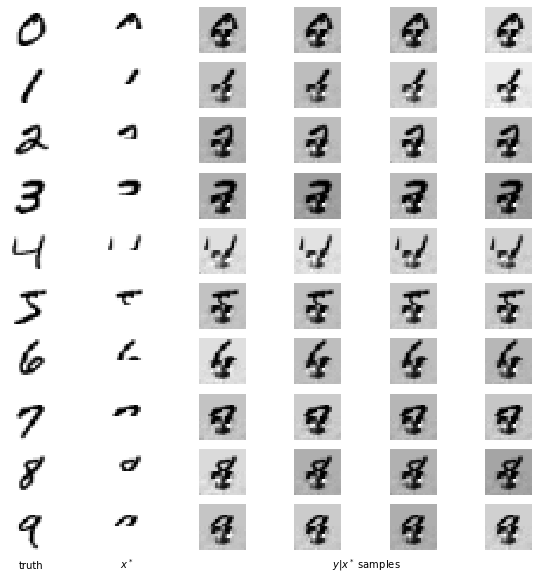

it: 15 time: 911.1525864601135 D loss: [0.6460513] G loss: [1.1685869]


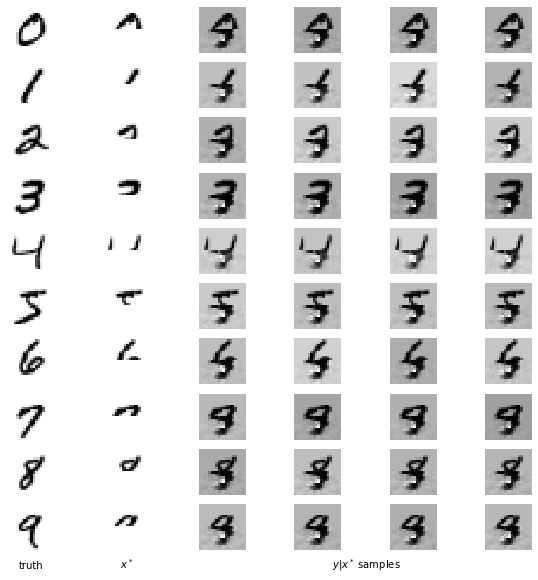

it: 20 time: 1197.1288244724274 D loss: [0.39874732] G loss: [1.7241535]


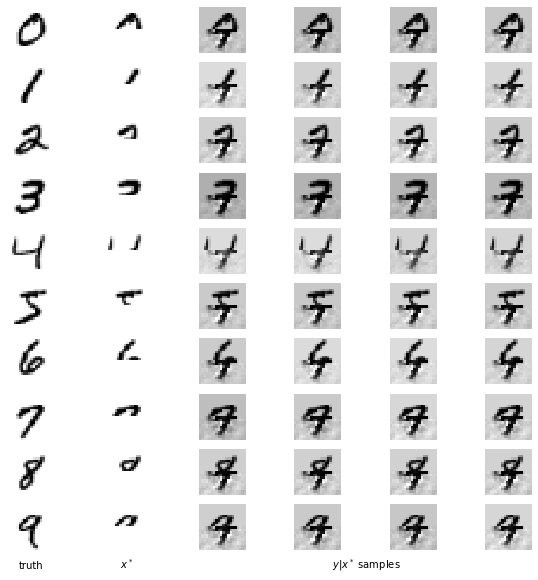

KeyboardInterrupt: 

In [9]:
# should implement train_step as part of model
# Then use tf.keras.callbacks.ModelCheckpoint
# or can implement checkpoint manually using tf.train.Checkpoint 

#checkpoint_dir = './training_checkpoints'
#checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
#checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
#                                 discriminator_optimizer=discriminator_optimizer,
#                                 generator=generator,
#                                 discriminator=discriminator)
lr = 1e-5
gen_opt = tf.keras.optimizers.Adam(learning_rate=lr,beta_1=0.5, epsilon=1e-8)
disc_opt = tf.keras.optimizers.Adam(learning_rate=lr,beta_1=0.5, epsilon=1e-8)

@tf.function
def train_step(x): 
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        g_loss = gen_loss()
        d_loss = disc_loss(x)
        
    gen_grad = gen_tape.gradient(g_loss, T.trainable_variables)
    disc_grad = disc_tape.gradient(d_loss, f.trainable_variables)
    
    gen_opt.apply_gradients(zip(gen_grad,T.trainable_variables))
    disc_opt.apply_gradients(zip(disc_grad,f.trainable_variables))
    
    return d_loss,g_loss

def train(dataset, epochs):
    t0 = time.time()
    for epoch in range(epochs):
        for data_batch in dataset:
            d_loss,g_loss = train_step(data_batch)
        if epoch % 5 == 0:
            t1 = time.time()
            print('it:',epoch,'time:',t1-t0,"D loss:",d_loss.numpy(),"G loss:",g_loss.numpy())
            grid_plot()
            
train(train_dataset,50)